In [2]:
import sys
sys.path.append("C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest")

import importlib

import config
import utils
import strat_test
importlib.reload(config)
importlib.reload(utils)
importlib.reload(strat_test)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging

In [3]:
# config
cfg = config.config

quote_dir = cfg['folder']['quote']

black_list = cfg['universe']['black']

full_list = cfg['full_bt']

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'retina'


## Load Data

In [4]:
# industry data
arch_dec_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "assembler", "arch_dec.csv")
auto_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "assembler", "auto.csv")
mech_equip_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "assembler", "mech_equip.csv")
real_estate_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "assembler", "real_estate.csv")
arch_dec = pd.read_csv(arch_dec_dir, index_col=0, parse_dates=True)
auto = pd.read_csv(auto_dir, index_col=0, parse_dates=True)
mech_equip = pd.read_csv(mech_equip_dir, index_col=0, parse_dates=True)
real_estate = pd.read_csv(real_estate_dir, index_col=0, parse_dates=True)
all_factors = pd.concat([arch_dec, auto, mech_equip, real_estate], axis=1)
all_factors = all_factors.loc[:, ~all_factors.columns.duplicated()]

# meta data
meta_dir = os.path.join(quote_dir, "QUOTE_INDUSTRY", "industry_parsed.csv")
meta = pd.read_csv(meta_dir, index_col=0)

# factor data
factors = pd.read_csv("data/backtest_single/ls_sharpe1_s.csv", index_col=None)

In [5]:
# futures data from quote basic
price_name = "open"

opens = pd.DataFrame()

for v in black_list:
    dir_path = os.path.join(quote_dir, "QUOTE_BASIC", "assembler", price_name, f"{v}.csv")
    df = pd.read_csv(dir_path, index_col=0, parse_dates=True)
    opens[v] = df[price_name]
    logger.info(f"Read {v} with {len(df)} rows")

# add black index
index_dir = os.path.join(quote_dir, "INDEX/black_open_index_qb.csv")
black_index = pd.read_csv(index_dir, index_col=0, parse_dates=True)
opens["black"] = black_index

INFO:__main__:Read FG with 2759 rows


INFO:__main__:Read hc with 2449 rows
INFO:__main__:Read i with 2553 rows
INFO:__main__:Read j with 3159 rows
INFO:__main__:Read jm with 2688 rows
INFO:__main__:Read rb with 3467 rows
INFO:__main__:Read SF with 2353 rows
INFO:__main__:Read SM with 2353 rows
INFO:__main__:Read SA with 1054 rows


## Composition of Factors for a single variety

In [6]:
opens.columns

Index(['FG', 'hc', 'i', 'j', 'jm', 'rb', 'SF', 'SM', 'SA', 'black'], dtype='object')

In [7]:
variety = "black"

In [8]:
# variety data loading
v_factors = factors[factors['variety'] == variety]
v_factors = v_factors.set_index('factor_code')
v_factors = v_factors.drop(index=meta[(meta['频率'] == "周") | (meta["频率"] == "日")].index, errors='ignore')
v_fac_data = all_factors[v_factors.index]
v_fac_data.columns = meta.loc[v_fac_data.columns, "INDEX_SHORT_NAME"]

<Axes: xlabel='INDEX_SHORT_NAME', ylabel='INDEX_SHORT_NAME'>

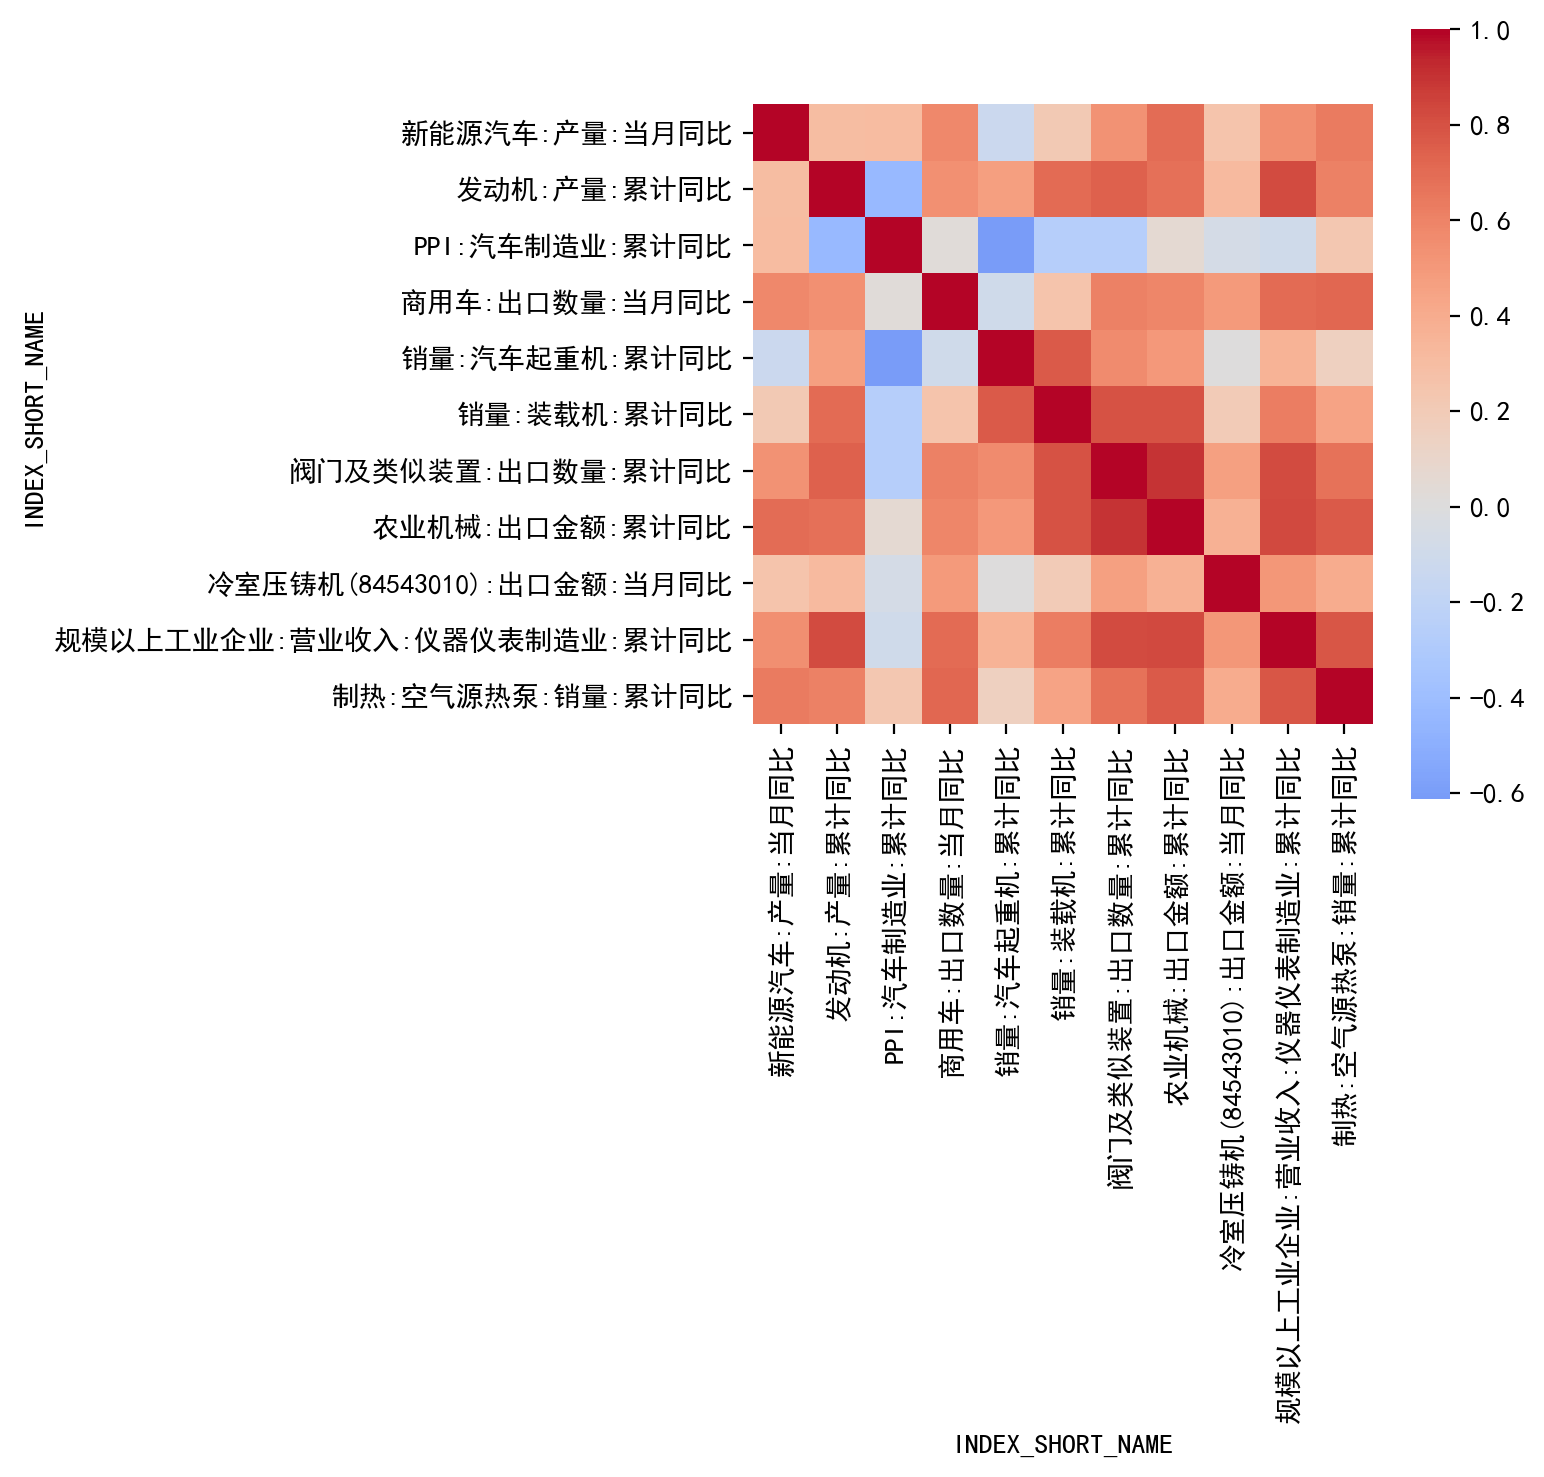

In [9]:
corr = v_fac_data.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True)

### Equal Weight

In [10]:
# variety data processing
v_scaled = utils.scale(v_fac_data.diff(), how="divstd")
v_comp = v_scaled.mean(axis=1)

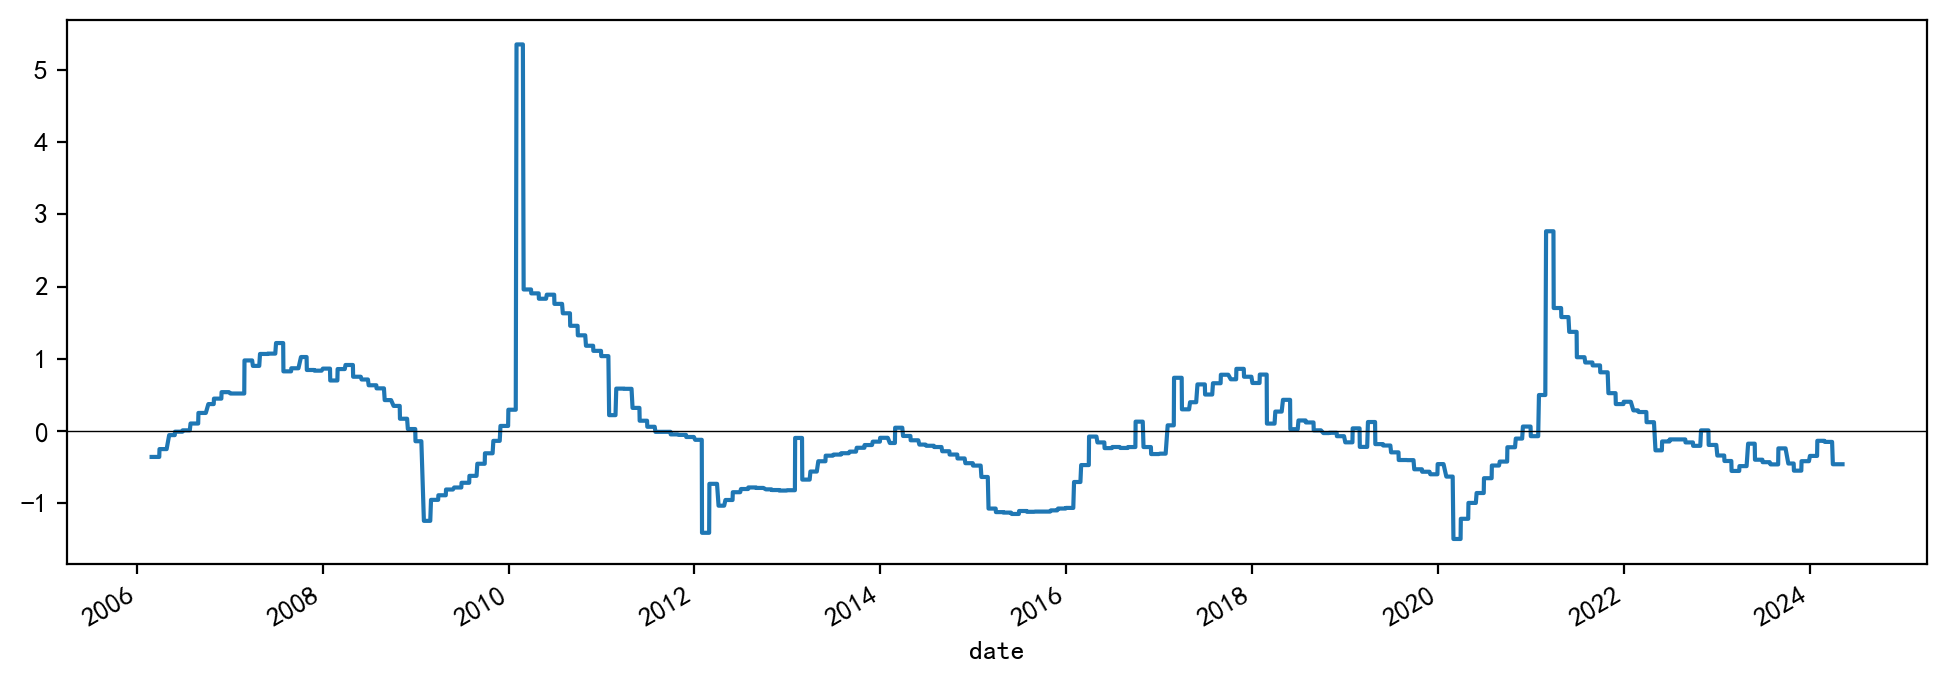

In [11]:
v_scaled = utils.scale(v_fac_data, how="standard")
v_comp = v_scaled.mean(axis=1)
v_comp.index.name = "date"
v_comp.plot()
plt.axhline(0, color="black", linewidth=0.5)
# v_comp.index = v_comp.index.format(formatter=lambda x: x.strftime("%Y%m%d"))
# v_comp.to_csv(f"data/{variety}_comp.csv")

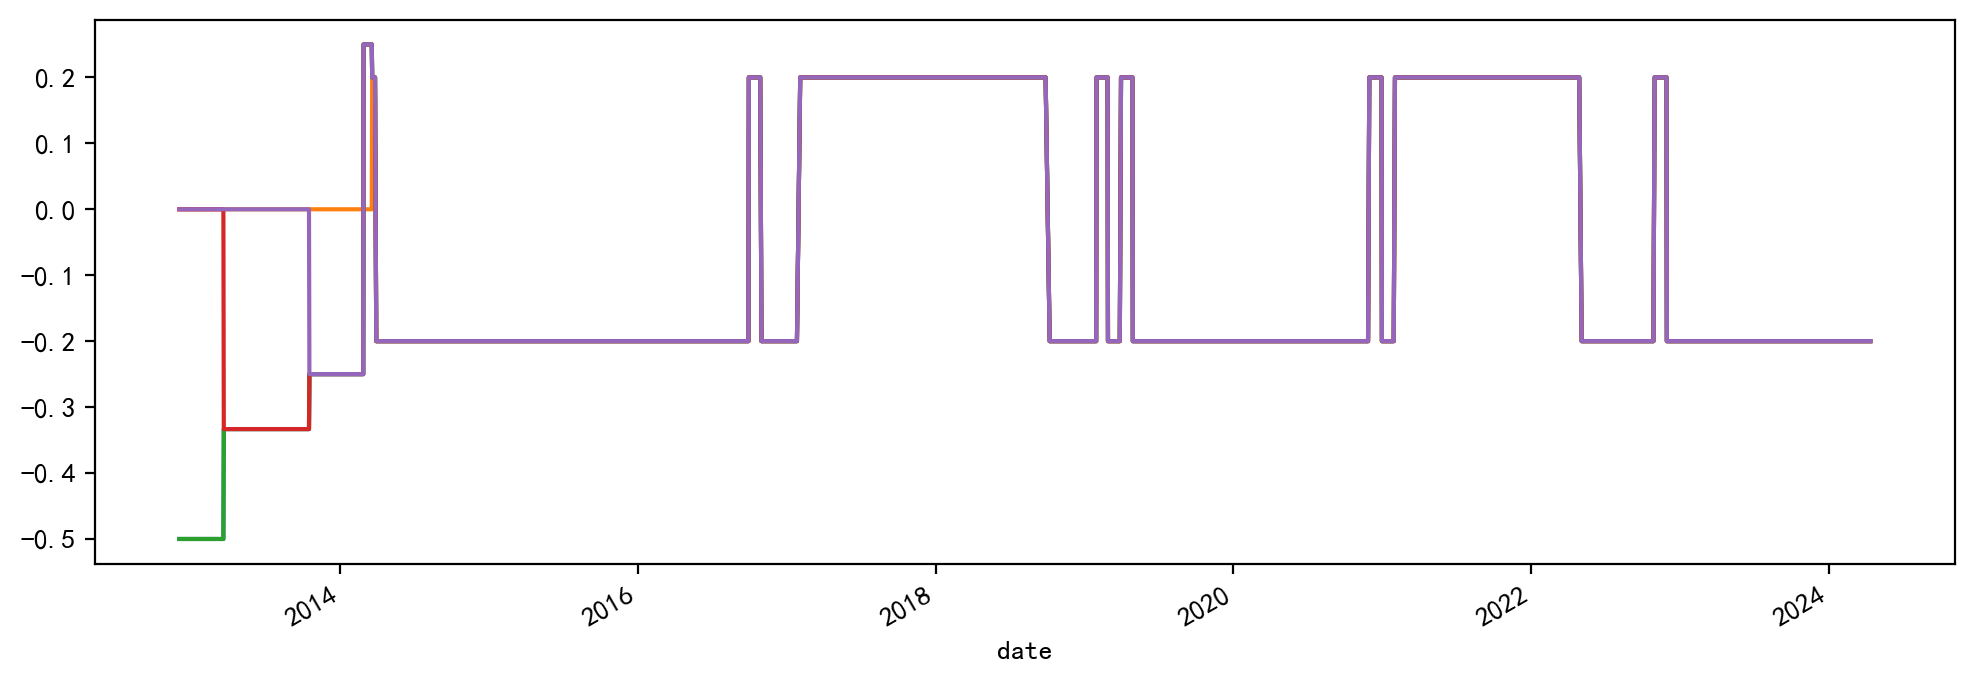

In [12]:
# posi = pd.read_csv("data/position/alpha_lbn_1_black.csv", index_col=0, parse_dates=True)
# posi = posi[posi["rb"] + posi["hc"] + posi["j"] + posi["jm"] + posi["i"] != 0]
# posi.plot()
posi = pd.Series(np.sign(v_comp), index=v_comp.index, name="posi")
typical = ["rb", "hc", "j", "jm", "i"]
# typical = black_list
# typical = "i"
mask = opens[typical].notna().astype(int)
posi = mask.mul(posi, axis=0)
posi = posi.div(abs(posi.sum(axis=1)), axis=0)
posi2bt = posi.copy()
posi2bt.index = posi2bt.index.strftime("%Y%m%d")
posi2bt.columns = posi2bt.columns.str.upper()
posi2bt = posi2bt.reindex(columns=full_list, fill_value=0)
posi2bt.to_csv(f"data/position/alpha_{variety}.csv")
ax = posi.plot(legend=False)

In [13]:
# # plot
# end_date = pd.to_datetime("2023-12-31")

# factor_name = f"{variety}_comp"
# price = opens[variety].loc[:end_date]
# factor = v_comp.loc[:end_date]
# price, factor = price.align(factor, join="inner")

# row_long, asset_long = utils.factor_test(price, factor, "long")
# row_ls, asset_ls = utils.factor_test(price, factor, "longshort")

# _, ax1 = plt.subplots(figsize=(12, 2))
# ax2 = ax1.twinx()

# ax1.plot(utils.scale(factor, "standard"), label=factor_name, color="black", linewidth=0.5)
# ax2.plot(utils.scale(asset_long, "1stvalue"), label="long")
# ax2.plot(utils.scale(asset_ls, "1stvalue"), label="longshort")
# ax2.plot(utils.scale(price, "1stvalue"), label=variety)
# ax1.axhline(0)
# ax1.plot(utils.scale(posi, "1stvalue"), label="posi")
# # ax1.legend(loc="upper left")
# # ax2.legend(loc="center left")

# title = f"({variety} {factor_name})"
# long_info = f"long: yr={row_long['yearly_return']:.2%}, eyr={row_long['exceed_yr']:.2%}, yv={row_long['yearly_vol']:.2%}, sp={row_long['sharpe']:.2f}, md={row_long['max_drawdown']:.2%}"
# short_info = f"longshort: yr={row_ls['yearly_return']:.2%}, eyr={row_ls['exceed_yr']:.2%}, yv={row_ls['yearly_vol']:.2%}, sp={row_ls['sharpe']:.2f}, md={row_ls['max_drawdown']:.2%}"
# plt.title(f"{title}\n{long_info}\n{short_info}")
# plt.show()

## Test Position

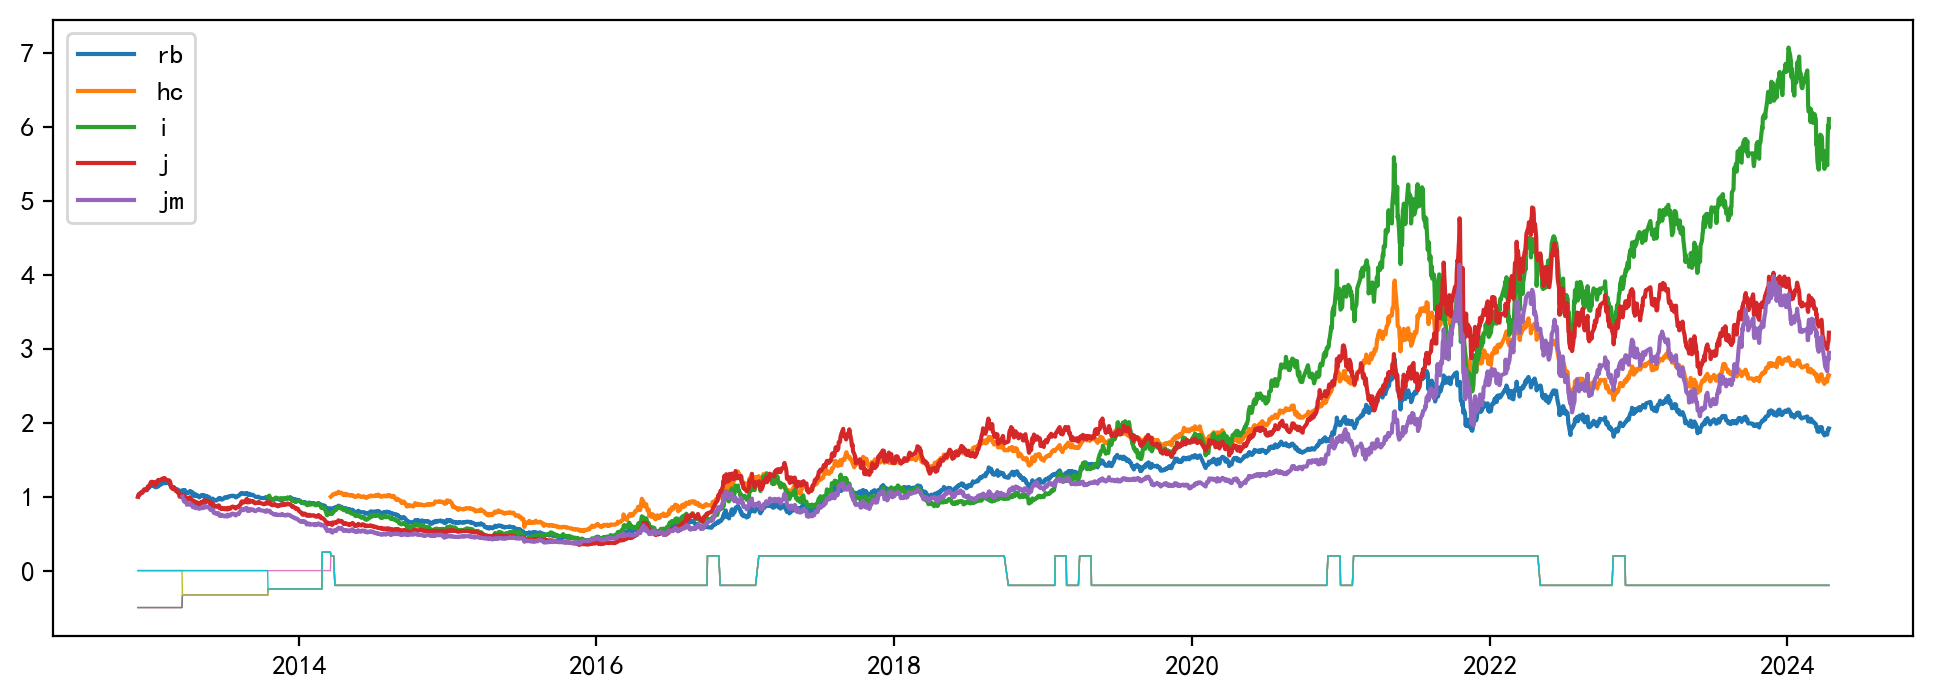

In [14]:
plt.plot(utils.scale(opens[["rb", "hc", "i", "j", "jm"]], "1stvalue"))
plt.plot(posi, linewidth=0.5)
plt.legend(["rb", "hc", "i", "j", "jm"])

In [15]:
!python backtest.py "black" "C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/data/position/alpha_black.csv"

保存多头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\black\black_多头.csv
保存空头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\black\black_空头.csv
保存全部持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\black\black.csv
读取持仓文件生成净值: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\black\black.csv
Figure(1200x800)
年化收益率 年化波动率 夏普率 最大回撤  最长回撤期 年换手率
    6.811%    24.893% 0.2736 -46.833%        1523  625.35%


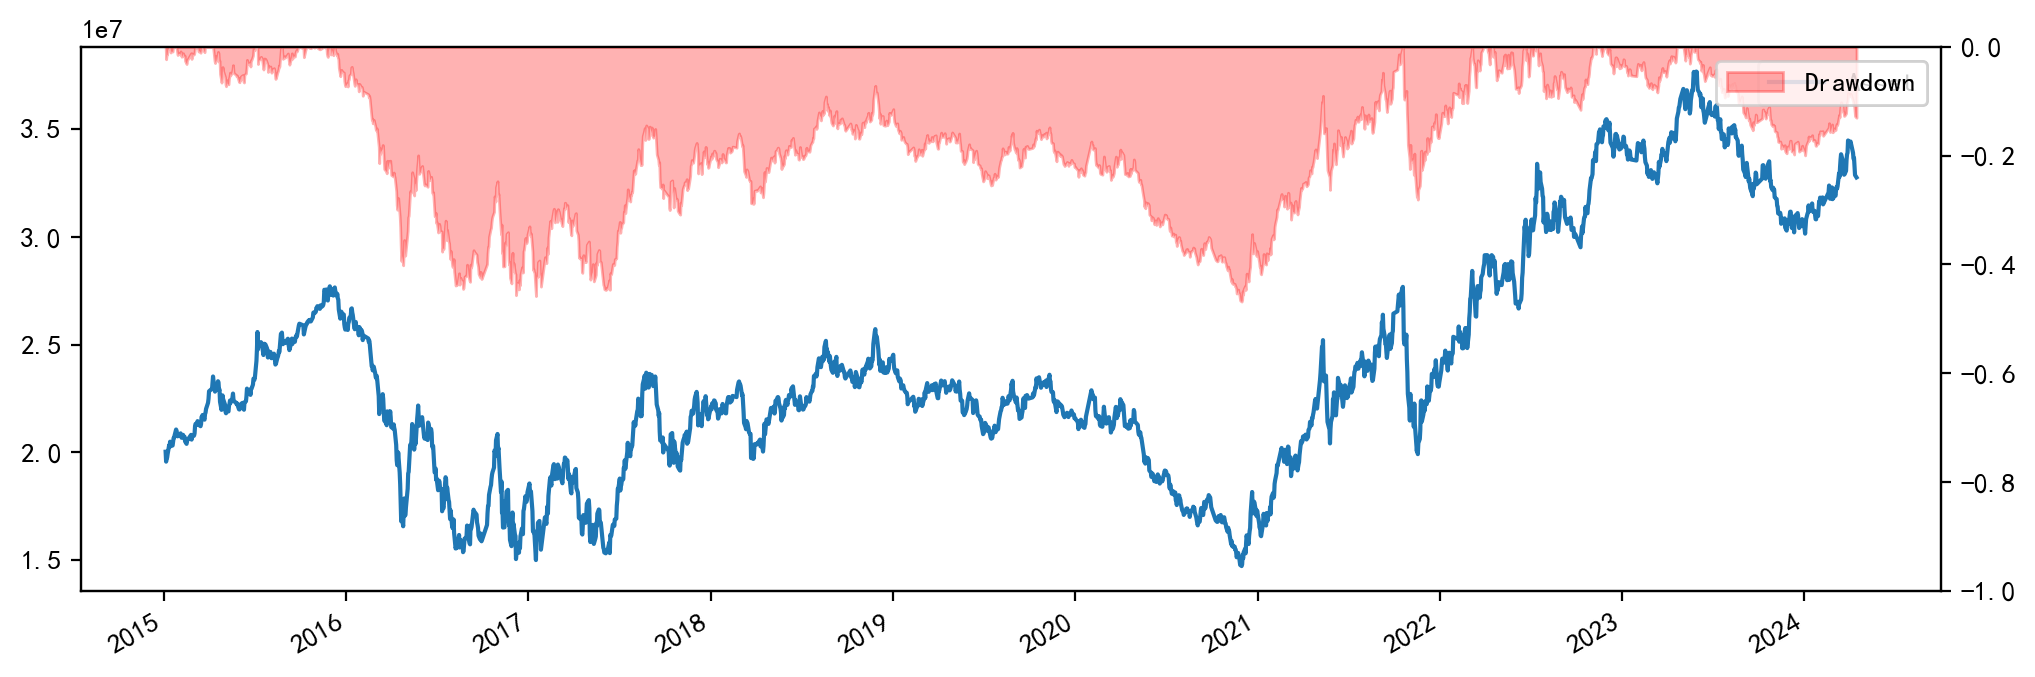

In [16]:
nworth = pd.read_csv("result/black/历史净值.csv", index_col=0, parse_dates=True, header=None)
nworth, posi = nworth.align(posi, join="inner", axis=0)
posi.iloc[-1] = posi.iloc[-2]
sp = strat_test.StratPerf(nworth, posi)
sp.plot()

In [17]:
sp.get_all()

,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2015,244,55.33,28.27,14.27,7.25,3.90,1.98,0.00,0.00,100.00,100.0
2016,244,48.36,-29.86,39.00,43.58,-0.69,-0.77,0.82,6.56,93.44,100.0
2017,244,52.05,17.11,36.44,22.48,0.76,0.47,0.41,92.62,7.38,100.0
2018,243,49.79,9.45,18.46,15.40,0.61,0.51,0.41,75.31,24.69,100.0
2019,244,50.00,-12.03,14.75,15.85,-0.76,-0.82,1.64,14.34,85.66,100.0
2020,243,42.39,-19.79,20.56,35.63,-0.56,-0.96,0.82,9.47,90.53,100.0
2021,243,56.79,38.93,31.80,28.02,1.39,1.22,0.41,91.77,8.23,100.0
2022,242,55.79,43.24,22.62,11.59,3.73,1.91,1.24,40.91,59.09,100.0
2023,242,47.11,-10.67,12.88,19.80,-0.54,-0.83,0.00,0.00,100.00,100.0
2024,67,56.72,7.83,7.00,4.97,1.57,1.12,0.00,0.00,100.00,100.0


<Axes: xlabel='0'>

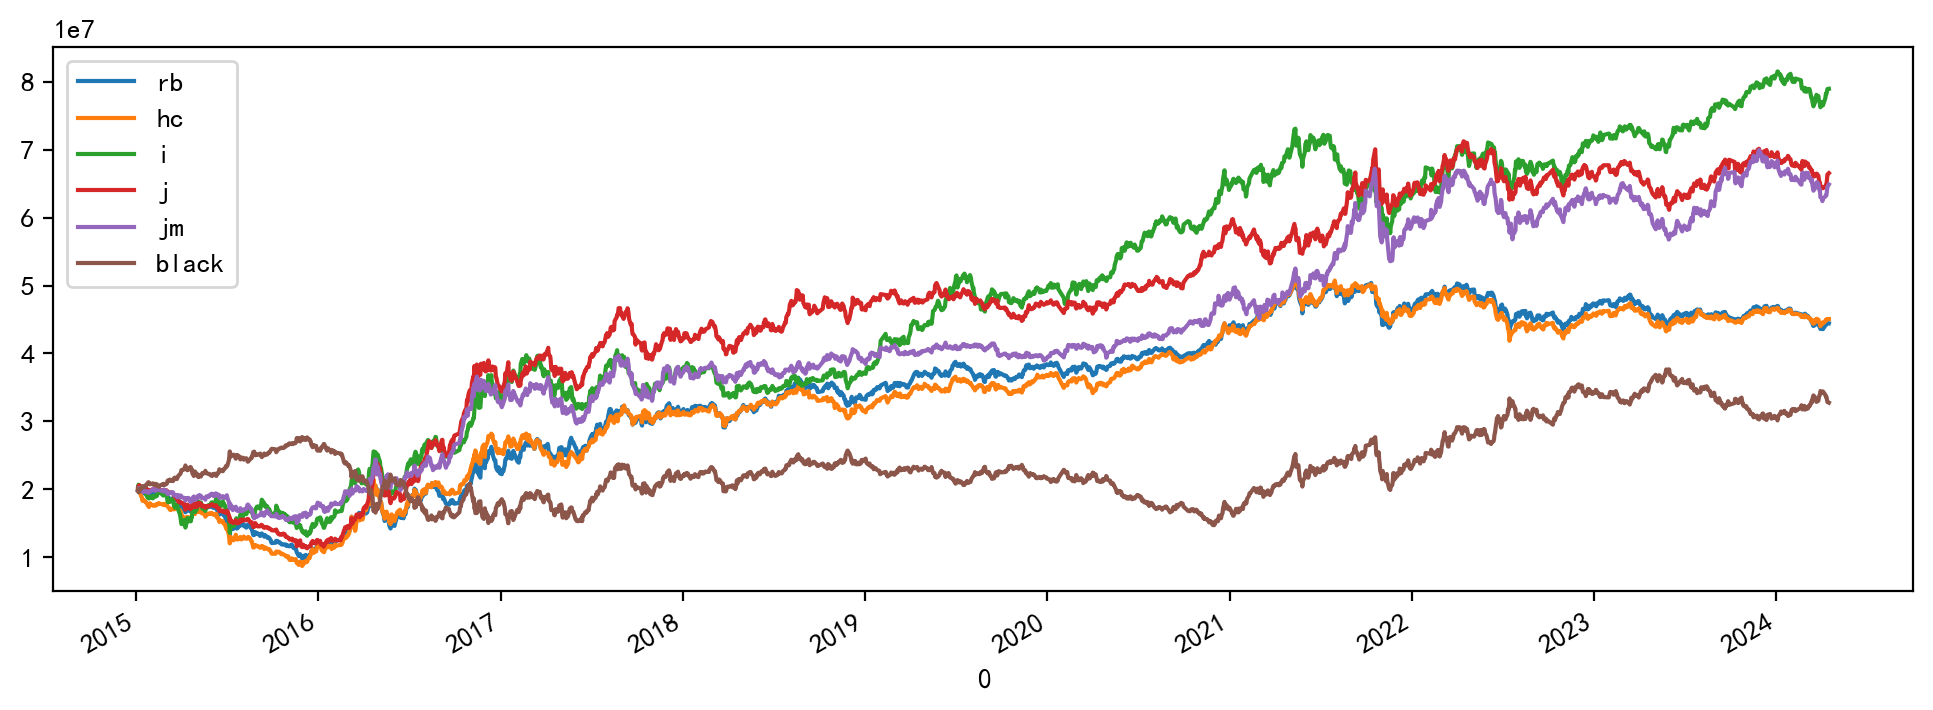

In [18]:
nworths = pd.DataFrame()
for v in ["rb", "hc", "i", "j", "jm", "black"]:
    tp_nworth = pd.read_csv(f"result/{v}/历史净值.csv", index_col=0, parse_dates=True, header=None)
    tp_nworth.columns = [v]
    nworths = pd.concat([nworths, tp_nworth], axis=1)

nworths.plot()